**1.0 Data Preparation (non-rerunnable, privacy-restriced)**

The comments have been extracted externally and uploaded into a dataset, accessible via google drive. This part reviews the data and prepares it by removing any deleted comments, adding a stable index and anonymising usernames for privacy reasons. The stable index ensures consistency during the thematic coding, especially considering the dataset may be reloaded which causes default indexes to change.

For privacy reasons, this part of the data analysis is not rerunable in Github, as the file contains the original authornames. For rerunning the code, please start from step **1.1 GitHub-Ready Code**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
file_path = "/content/drive/MyDrive/Dataprojects/Methodology/videoinfo_SdSSPF1S-Uc&t=24s_2025_10_16-23_09_59_comments.csv"
df_new = pd.read_csv(file_path)

print(f"✅ Loaded {len(df_new):,} rows from {file_path}")
pd.set_option('display.max_colwidth', None)
df_new['text'].head(10)


In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/Dataprojects/Methodology/videoinfo_SdSSPF1S-Uc&t=24s_2025_10_16-23_09_59_comments.csv"
df_raw = pd.read_csv(file_path)

print(f"📥 Loaded {len(df_raw):,} rows")

text_col = None
for c in ["text", "comment", "body", "content"]:
    if c in df_raw.columns:
        text_col = c
        break

if text_col is None:
    raise ValueError("❌ No comment text column found")

print(f"📝 Using text column: {text_col}")

df = df_raw.copy()

mask_blank = (
    df[text_col].isna() |
    df[text_col].astype(str).str.strip().eq("")
)

num_blank = mask_blank.sum()
num_total = len(df)

print(f"\n🗑️ Blank / unavailable comments detected: {num_blank:,}")
print(f"📊 Share of dataset removed: {num_blank / num_total * 100:.2f}%")

df_clean = df[~mask_blank].copy()

df_clean = df_clean.reset_index(drop=True)
df_clean["stable_comment_index"] = df_clean.index

print(f"✨ Cleaned dataset size: {len(df_clean):,}")

USERNAME_COL = "authorName"

if USERNAME_COL not in df_clean.columns:
    raise ValueError(f"❌ Username column '{USERNAME_COL}' not found")

unique_authors = df_clean[USERNAME_COL].dropna().unique()
author_to_anon = {author: f"User_{i+1}" for i, author in enumerate(unique_authors)}

df_clean["user_anonymised"] = df_clean[USERNAME_COL].map(author_to_anon)
df_clean["user_anonymised"] = df_clean["user_anonymised"].fillna("user_deleted")

print(f"👤 Created 'user_anonymised' for {len(unique_authors):,} users.")

df_clean.drop(columns=[USERNAME_COL], inplace=True)
print(f"🔒 Dropped identifying column: '{USERNAME_COL}'")

final_output_path = "/content/drive/MyDrive/Dataprojects/Methodology/youtube_final_dataset.csv"
df_clean.to_csv(final_output_path, index=False)

print(f"\n💾 Final dataset saved to:")
print(final_output_path)
print(f"📌 Total final comments: {len(df_clean):,}")


**1.1 GitHub-Ready Code**


In [1]:
# --- Fresh clone (no cache) ---
import shutil
from pathlib import Path
import os

REPO = "data-analysis-YouTube"

if Path(REPO).exists():
    shutil.rmtree(REPO)

!git clone https://github.com/salomevanzutphen/data-analysis-YouTube.git
os.chdir(REPO)

!ls -lh data/dataset/youtube_final_dataset.csv

Cloning into 'data-analysis-YouTube'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 30 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 1.57 MiB | 7.83 MiB/s, done.
Resolving deltas: 100% (7/7), done.
-rw-r--r-- 1 root root 3.1M Jan  3 19:11 data/dataset/youtube_final_dataset.csv


In [2]:
from pathlib import Path
import pandas as pd

df_youtube = pd.read_csv("data/dataset/youtube_final_dataset.csv")
print(df_youtube.shape)
df_youtube.head()

(19968, 10)


,id,replyCount,likeCount,publishedAt,text,isReply,isReplyTo,isReplyToName,stable_comment_index,user_anonymised
0,eb9202bc71246bc4aa35691682b45f2aede8296b,0.0,0,2025-10-16 23:08:48,ok they kinda ate with this xxxxx. Madison Bee...,0,NaN,NaN,0,User_1
1,8d0221be99a4e7fb251aeb683b36d81f4d9e1946,0.0,0,2025-10-16 23:08:47,"1:13:31 Wow! Olha o bronze da gata, Bela Hadid...",0,NaN,NaN,1,User_2
2,eed57fb6500062ef4f9de5daf872a349e89d97f9,0.0,1,2025-10-16 23:08:37,Alessandra as always the besssssst and GOAT,0,NaN,NaN,2,User_3
3,0def816c3bb962121e397fffed8b171e4df4dd67,0.0,0,2025-10-16 23:08:27,"1:13:31 Wow! Olha o bronze da gata, Bela Hadid...",0,NaN,NaN,3,User_2
4,4ed67c8bdb9ae10f441fed2b5e199195bee8c43b,0.0,0,2025-10-16 23:08:24,Angel Reese!!!!!!!!!!!!!!!!,0,NaN,NaN,4,User_4


In [3]:
from pathlib import Path
import pandas as pd


CANDIDATE_PATHS = [
    Path("data/dataset/youtube_final_dataset.csv"),
    Path("../data/dataset/youtube_final_dataset.csv"),
]

CLEAN_YOUTUBE_DATA = next((p for p in CANDIDATE_PATHS if p.exists()), None)
if CLEAN_YOUTUBE_DATA is None:
    raise FileNotFoundError(
        "Could not find youtube_final_dataset.csv.\n"
        "Expected it at data/dataset/youtube_final_dataset.csv"
    )

df_youtube = pd.read_csv(CLEAN_YOUTUBE_DATA)
print(f"✅ Loaded {len(df_youtube):,} YouTube rows from: {CLEAN_YOUTUBE_DATA}")


✅ Loaded 19,968 YouTube rows from: data/dataset/youtube_final_dataset.csv


**1.2 Reviewing Duplicate Comments**

This part includes reviewing the metrics of identical comments, to determine whether they are true or accidental duplications.

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from IPython.display import display


df_youtube = pd.read_csv(CLEAN_YOUTUBE_DATA)
print(f"Loaded {len(df_youtube):,} YouTube rows")

text_col = "text"

df_youtube["publishedAt"] = pd.to_datetime(df_youtube["publishedAt"], errors="coerce")

duplicate_counts = df_youtube[text_col].value_counts()
duplicate_texts = duplicate_counts[duplicate_counts > 1].index.tolist()

print(f"🔍 Found {len(duplicate_texts)} duplicated unique YouTube comments.")

duplicates_full = df_youtube[df_youtube[text_col].isin(duplicate_texts)].copy()

def summarize_group(g):
    g = g.sort_values("publishedAt")

    freq = len(g)

    rows = []
    for _, r in g.iterrows():
        rows.append(
            f"user={r.get('user_anonymised', '')}, "
            f"likes={r.get('likeCount', '')}, "
            f"publishedAt={r.get('publishedAt', '')}"
        )

    instances_str = "\n".join(rows)

    return pd.Series({
        "frequency": freq,
        "instances": instances_str
    })

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    summary_youtube = duplicates_full.groupby(text_col).apply(summarize_group).reset_index()

summary_youtube = summary_youtube.sort_values("frequency", ascending=False).reset_index(drop=True)

summary_youtube.index = summary_youtube.index + 1

# Display table
pd.set_option("display.max_colwidth", None)

display(
    summary_youtube.style.set_properties(
        subset=[text_col],
        **{
            "white-space": "normal",
            "max-width": "300px",
        }
    ).set_properties(
        subset=["instances"],
        **{
            "white-space": "pre-wrap",
            "max-width": "1000px",
            "font-family": "monospace"
        }
    )
)


Loaded 19,968 YouTube rows
🔍 Found 359 duplicated unique YouTube comments.


,text,frequency,instances
1,❤❤❤,55,"user=User_14639, likes=0, publishedAt=2025-10-16 00:13:34 user=User_14642, likes=0, publishedAt=2025-10-16 00:13:47 user=User_14433, likes=0, publishedAt=2025-10-16 00:16:09 user=User_14070, likes=0, publishedAt=2025-10-16 00:21:18 user=User_13255, likes=0, publishedAt=2025-10-16 00:37:40 user=User_13238, likes=0, publishedAt=2025-10-16 00:37:58 user=User_13105, likes=0, publishedAt=2025-10-16 00:38:05 user=User_12962, likes=0, publishedAt=2025-10-16 00:45:52 user=User_12812, likes=0, publishedAt=2025-10-16 00:50:07 user=User_12749, likes=0, publishedAt=2025-10-16 00:51:13 user=User_12725, likes=0, publishedAt=2025-10-16 00:51:57 user=User_11935, likes=10, publishedAt=2025-10-16 00:52:35 user=User_12590, likes=0, publishedAt=2025-10-16 00:55:56 user=User_12348, likes=0, publishedAt=2025-10-16 01:03:31 user=User_12327, likes=0, publishedAt=2025-10-16 01:04:12 user=User_12258, likes=0, publishedAt=2025-10-16 01:06:34 user=User_12198, likes=2, publishedAt=2025-10-16 01:08:54 user=User_11936, likes=0, publishedAt=2025-10-16 01:17:28 user=User_11438, likes=0, publishedAt=2025-10-16 01:34:54 user=User_11171, likes=0, publishedAt=2025-10-16 01:45:32 user=User_11153, likes=0, publishedAt=2025-10-16 01:46:10 user=User_10631, likes=0, publishedAt=2025-10-16 02:12:05 user=User_10601, likes=0, publishedAt=2025-10-16 02:13:13 user=User_10470, likes=0, publishedAt=2025-10-16 02:18:49 user=User_10379, likes=0, publishedAt=2025-10-16 02:24:51 user=User_9900, likes=0, publishedAt=2025-10-16 02:49:26 user=User_9845, likes=0, publishedAt=2025-10-16 02:52:57 user=User_9825, likes=0, publishedAt=2025-10-16 02:54:10 user=User_9763, likes=0, publishedAt=2025-10-16 02:57:51 user=User_9564, likes=0, publishedAt=2025-10-16 03:08:27 user=User_9464, likes=0, publishedAt=2025-10-16 03:14:49 user=User_9407, likes=0, publishedAt=2025-10-16 03:19:03 user=User_9150, likes=0, publishedAt=2025-10-16 03:35:44 user=User_8570, likes=0, publishedAt=2025-10-16 04:14:30 user=User_8478, likes=0, publishedAt=2025-10-16 04:20:25 user=User_7670, likes=0, publishedAt=2025-10-16 05:13:48 user=User_7439, likes=0, publishedAt=2025-10-16 05:30:50 user=User_7383, likes=0, publishedAt=2025-10-16 05:35:06 user=User_7353, likes=0, publishedAt=2025-10-16 05:37:19 user=User_7101, likes=0, publishedAt=2025-10-16 05:55:57 user=User_6951, likes=0, publishedAt=2025-10-16 06:04:00 user=User_6495, likes=1, publishedAt=2025-10-16 06:44:21 user=User_6229, likes=0, publishedAt=2025-10-16 07:09:52 user=User_5809, likes=0, publishedAt=2025-10-16 07:48:30 user=User_5273, likes=0, publishedAt=2025-10-16 08:52:55 user=User_4861, likes=0, publishedAt=2025-10-16 09:46:52 user=User_4564, likes=0, publishedAt=2025-10-16 10:23:46 user=User_4241, likes=0, publishedAt=2025-10-16 10:59:28 user=User_4234, likes=0, publishedAt=2025-10-16 11:00:38 user=User_4193, likes=0, publishedAt=2025-10-16 11:05:04 user=User_2895, likes=0, publishedAt=2025-10-16 13:55:00 user=User_2836, likes=0, publishedAt=2025-10-16 14:03:14 user=User_1793, likes=0, publishedAt=2025-10-16 16:38:13 user=User_1361, likes=0, publishedAt=2025-10-16 17:47:01 user=User_1133, likes=1, publishedAt=2025-10-16 18:27:07"
2,❤,40,"user=User_16091, likes=1, publishedAt=2025-10-16 00:06:57 user=User_14781, likes=0, publishedAt=2025-10-16 00:12:28 user=User_14253, likes=0, publishedAt=2025-10-16 00:18:20 user=User_13187, likes=0, publishedAt=2025-10-16 00:39:28 user=User_12921, likes=0, publishedAt=2025-10-16 00:47:20 user=User_12739, likes=0, publishedAt=2025-10-16 00:51:26 user=User_11954, likes=0, publishedAt=2025-10-16 01:17:01 user=User_11802, likes=5, publishedAt=2025-10-16 01:24:03 user=User_11557, likes=0, publishedAt=2025-10-16 01:30:21 user=User_11557, likes=0, publishedAt=2025-10-16 01:30:24 user=User_11557, likes=1, publishedAt=2025-10-16 01:30:27 user=User_11367, likes=0, publishedAt=2025-10-16 01:36:56 user=User_11341, likes=0, publishedAt=2025-10-16 01:38:17 user=User_10964, likes=0, publishedAt=20

**2.0 Opinion Leaders**

The opinion leaders are identified using the benchmark of 75% of the total likecount/upvotes of the overall dataset. After knowing how many comments are in this subset, they are reviewed with their ranking, stable index, like count and text.

In [5]:
import pandas as pd

df = pd.read_csv(CLEAN_YOUTUBE_DATA)

LIKES_COL = "likeCount"


if LIKES_COL not in df.columns:
    raise ValueError(f"Column '{LIKES_COL}' not found. Available columns: {list(df.columns)}")


df = df[df[LIKES_COL].notna() & (df[LIKES_COL] >= 0)]


total_comments = len(df)
total_likes = df[LIKES_COL].sum()


if total_comments == 0 or total_likes == 0:
    print("No comments or no likes in the dataset.")
else:
    # 75% benchmark of the total likes
    target_likes_75 = 0.75 * total_likes

    df_sorted = df.sort_values(LIKES_COL, ascending=False).reset_index(drop=True)
    df_sorted["cum_likes"] = df_sorted[LIKES_COL].cumsum()

    first_row_reaching_75 = df_sorted[df_sorted["cum_likes"] >= target_likes_75].index.min()
    comments_needed = int(first_row_reaching_75) + 1

    percent_of_dataset = (comments_needed / total_comments) * 100


    print(f"Total comments: {total_comments:,}")
    print(f"Total likes: {total_likes:,}")
    print(f"75% benchmark of total likes: {target_likes_75:,.0f}")
    print(f"Comments needed to reach 75% of likes: {comments_needed:,}")
    print(f"These comments represent {percent_of_dataset:.2f}% of the dataset.")


Total comments: 19,968
Total likes: 376,234
75% benchmark of total likes: 282,176
Comments needed to reach 75% of likes: 35
These comments represent 0.18% of the dataset.


In [6]:
import pandas as pd

df = pd.read_csv(CLEAN_YOUTUBE_DATA)

LIKES_COL = "likeCount"
TEXT_COL = "text"


if LIKES_COL not in df.columns:
    raise ValueError(f"Column '{LIKES_COL}' not found. Available columns: {list(df.columns)}")

if TEXT_COL not in df.columns:
    raise ValueError(f"Column '{TEXT_COL}' not found. Available columns: {list(df.columns)}")


opinionleaders_youtube = (
    df.sort_values(LIKES_COL, ascending=False)
      .head(35)
      .copy()
)

# Preserve original index
opinionleaders_youtube["index"] = opinionleaders_youtube.index


opinionleaders_youtube.index = range(1, len(opinionleaders_youtube) + 1)
opinionleaders_youtube.index.name = None


opinionleaders_youtube = opinionleaders_youtube[[LIKES_COL, "index", TEXT_COL]]


styled_table_youtube = opinionleaders_youtube.style.set_properties(
    subset=[TEXT_COL],
    **{
        "white-space": "normal",
        "word-wrap": "break-word",
        "width": "550px"
    }
)

styled_table_youtube


,likeCount,index,text
1,36146,18671,Opening with pregnant Jasmine was the bomb! Couldn't believe my eyes!!! LOVED it!
2,34945,14037,100000 times better than last year. Thank you for listening to the people!! Stunning fabulous work from everyone
3,23862,9411,Bringing the OGs back was the best choice
4,18183,9490,"The level of confidence and femininity that the ""main"" angels bring with them is exactly why we all watched the show"
5,15514,10402,bring back the backstage shots of the girls dancing and vibing to EVERY performance
6,14386,19552,This was the first Victoria’s Secret show I’ve ever watched. And it was perfect ❤
7,13720,14457,This is the first VS Fashion Show I’ve fully watched in YEARS. This was SO GOOD and Quenlin ATE!!
8,12936,17673,"""This is for all my ladies""."
9,11099,13333,"Whoever was in charge this year, knew the assignment. Great bend of what was and what’s new, glamour, drama, inclusivity, great looks, music. Loveeeeed"
10,9862,10447,I love how all the singers brought a different vibe to the event


**2.1 Thematic Analysis**

This part categorizes each comment within the subset of opinion leaders. The following themes have been identified:

-  **Nostalgia & Comeback Angels**: Appreciation for the original models and nostalgic elements of the traditional VS shows
- **VS Show Production**: Regarding the overall experience of watching the show & highlighting certain segments or specific elements
-   **Inclusivity**: Positive feedback on a variety of cultures, sizes, races, etc.
-   **Music Artists**: Regarding the performances and artists
-   **Sisterhood**: Highlighting discourse surrounding women's empowerment and the collective identity of girls
-   **Year on Year**: Highlighting this year's improvement & comparisons to last year
-   **Specific Model References**: Specifically about particular models and their stage performance
-   **Timestamps**: Listing times of performances, etc.

Below follows the thematic distribution of comments and likecounts, visualised in a pie chart. Furthermore, all comments and their related themes are be provided as well.

Loaded YouTube dataset with 19,968 rows.
✅ All top-35 comments have at least one theme label.

📊 THEME SUMMARY (Top 35 YouTube Comments)

                             Comments  Likes  Share of Likes (%)
theme                                                           
Nostalgia & Comeback Angels         9  80550                23.5
Year on Year                        5  61868                18.0
Specific Model References           4  59452                17.3
Music Artists                      11  50116                14.6
VS ShowProduction                   7  49279                14.4
Sisterhood                          4  20634                 6.0
Inclusivity                         3  15926                 4.6
Timestamps                          2   4968                 1.4


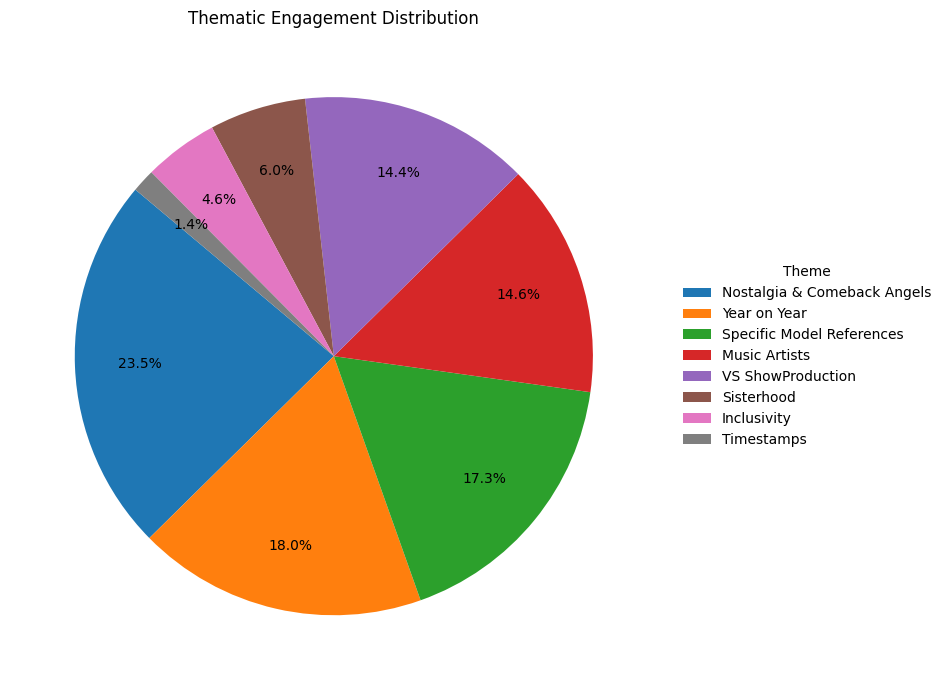


📁 Saved labeled top-35 to: data/processed/top35_youtube_comments_labeled_by_theme.csv


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

df_clean = pd.read_csv(CLEAN_YOUTUBE_DATA)
print(f"Loaded YouTube dataset with {len(df_clean):,} rows.")

themes_by_index = {
    "Nostalgia & Comeback Angels": [9411, 9490, 10402, 12158, 15288, 6338, 19051, 12483, 17573],
    "Inclusivity": [13333, 7152, 8481],
    "VS ShowProduction": [19552, 14457, 13333, 15288, 2817, 15498, 5575],
    "Music Artists": [10447, 7549, 12158, 18322, 19023, 3051, 16332, 15498, 11539, 4070, 17573],
    "Timestamps": [16694, 3538],
    "Sisterhood": [17673, 19051, 17901, 7152],
    "Year on Year": [13333, 19318, 16141, 4070, 14037],
    "Specific Model References": [18671, 14457, 8125, 19278],
}

candidate_cols = []
for c in df_clean.columns:
    cl = c.lower()
    if cl in ["text", "content", "body", "comment", "likecount", "score"]:
        candidate_cols.append(c)

if not candidate_cols:
    raise ValueError(
        "No usable columns found. Expected one of: text/content/body/comment and likeCount/score."
    )

subset = df_clean[candidate_cols].copy()

text_col = None
for c in subset.columns:
    if c.lower() in ["text", "content", "body", "comment"]:
        text_col = c
        break
if text_col is None:
    raise ValueError("No text column found (expected 'text', 'content', 'body', or 'comment').")

likes_col = None
for c in subset.columns:
    if c.lower() in ["likecount", "score"]:
        likes_col = c
        break
if likes_col is None:
    raise ValueError("No likes column found (expected 'likeCount' or 'score').")

subset = subset.rename(columns={text_col: "comment", likes_col: "likeCount"})

subset["likeCount"] = subset["likeCount"].fillna(0).astype(int)
subset["comment"] = subset["comment"].astype(str).fillna("").str.strip()

top_comments_df = (
    subset.sort_values("likeCount", ascending=False)
          .head(35)[["comment", "likeCount"]]
          .copy()
)

ranked = top_comments_df.reset_index().rename(columns={"index": "orig_index"})


index_to_themes = {}
for theme, indices in themes_by_index.items():
    for idx in indices:
        index_to_themes.setdefault(idx, []).append(theme)

def join_labels(idx):
    labels = index_to_themes.get(idx, [])
    return ", ".join(labels) if labels else ""

ranked["themes"] = ranked["orig_index"].apply(join_labels)

missing = ranked.loc[ranked["themes"].eq(""), "orig_index"].tolist()
if missing:
    print(f"⚠️ Dataset indices in top-35 with no theme label: {missing}")
else:
    print("✅ All top-35 comments have at least one theme label.")

ranked["theme_list"] = ranked["themes"].apply(
    lambda x: x.split(", ") if isinstance(x, str) and x else []
)

long = ranked.explode("theme_list").rename(columns={"theme_list": "theme"})
long = long[long["theme"] != ""]


counts = long.groupby("theme")["orig_index"].nunique().sort_values(ascending=False)
likes = long.groupby("theme")["likeCount"].sum().sort_values(ascending=False)

total_likes = likes.sum()

summary_df = pd.DataFrame({
    "Comments": counts,
    "Likes": likes,
    "Share of Likes (%)": (likes / total_likes * 100).round(1),
}).sort_values("Likes", ascending=False)

print("\n📊 THEME SUMMARY (Top 35 YouTube Comments)\n")
print(summary_df.to_string())

# --- Plot ---
plt.figure(figsize=(10, 7))

wedges, texts, autotexts = plt.pie(
    summary_df["Likes"],
    labels=None,
    autopct="%1.1f%%",
    startangle=140,
    pctdistance=0.75
)

plt.title("Thematic Engagement Distribution")

plt.legend(
    wedges,
    summary_df.index,
    title="Theme",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()

# --- GitHub-ready output path (stable) ---
OUTPUT_DIR = Path("data/processed")
if not OUTPUT_DIR.exists():
    alt = Path("../data/processed")
    if alt.parent.exists():
        OUTPUT_DIR = alt

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_PATH = OUTPUT_DIR / "top35_youtube_comments_labeled_by_theme.csv"
ranked.to_csv(OUT_PATH, index=False, encoding="utf-8")
print(f"\n📁 Saved labeled top-35 to: {OUT_PATH}")


In [8]:
import pandas as pd
import textwrap
from pathlib import Path

# --- Find the labeled file in common locations ---
CANDIDATE_PATHS = [
    Path("data/processed/top35_youtube_comments_labeled_by_theme.csv"),
    Path("../data/processed/top35_youtube_comments_labeled_by_theme.csv"),
]

LABELED_PATH = next((p for p in CANDIDATE_PATHS if p.exists()), None)
if LABELED_PATH is None:
    raise FileNotFoundError(
        "Could not find the labeled CSV. Run the previous code block first to generate it.\n"
        "Expected: data/processed/top35_youtube_comments_labeled_by_theme.csv"
    )

df_labeled_comments = pd.read_csv(LABELED_PATH)
print(f"✅ Loaded labeled comments from: {LABELED_PATH}")

if "index" in df_labeled_comments.columns:
    df_labeled_comments = df_labeled_comments.rename(columns={"index": "orig_index"})

df_labeled_comments["themes"] = df_labeled_comments["themes"].apply(
    lambda x: [theme.strip() for theme in x.split(",")] if pd.notna(x) and x else []
)

all_unique_themes = sorted(
    {theme for sublist in df_labeled_comments["themes"] for theme in sublist}
)

MAX_WIDTH = 100

print("\n=== YouTube Comments by Theme (Top 35) ===\n")

for theme in all_unique_themes:
    print(f"\n--- 🔵 Theme: {theme} ---")

    theme_comments = df_labeled_comments[
        df_labeled_comments["themes"].apply(lambda x: theme in x)
    ]

    if theme_comments.empty:
        print(f"  No comments found for '{theme}'.")
        continue

    theme_comments = theme_comments.sort_values(by="likeCount", ascending=False)

    for i, row in enumerate(theme_comments.itertuples(index=False), start=1):
        wrapped_comment = textwrap.fill(
            row.comment,
            width=MAX_WIDTH,
            break_long_words=False,
            replace_whitespace=False,
        )
        print(f"  {i}.  {row.likeCount} likes  |  Original Index: {row.orig_index}")
        print(f"     {wrapped_comment}")
        print("-" * MAX_WIDTH)


✅ Loaded labeled comments from: data/processed/top35_youtube_comments_labeled_by_theme.csv

=== YouTube Comments by Theme (Top 35) ===


--- 🔵 Theme: Inclusivity ---
  1.  11099 likes  |  Original Index: 13333
     Whoever was in charge this year, knew the assignment. Great bend of what was and what’s new,
glamour, drama, inclusivity, great looks, music. Loveeeeed
----------------------------------------------------------------------------------------------------
  2.  2978 likes  |  Original Index: 7152
     Pregnant Woman, Bisexual performers, REAL Plus size Women, All Female Voices. THIS SHOW WAS
ABSOLUTELY PERFECT! A TRUE GIRLS DAY🥰
----------------------------------------------------------------------------------------------------
  3.  1849 likes  |  Original Index: 8481
     As an OLD millennial, you did your thing with this show! Models were diverse and gorgeous and the
musical acts were multi-cultural and entertaining. 100/10 KUDOS to the VS team!
-----------------------------

**3.0 Sentiment Analysis**


This includes a sentiment analysis on the overall dataset, as well as a manual review of 100 comments. Here, the doubtful or incorrect classifications are separated for closer review, before calculating the accuracy rate.  

In [9]:
!pip install -q transformers torch

import pandas as pd
import torch
import time
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

df = pd.read_csv(CLEAN_YOUTUBE_DATA)
print(f"✅ Loaded {len(df):,} YouTube rows from:\n{CLEAN_YOUTUBE_DATA}")

# --- GitHub-ready output path (stable) ---
# Default assumes running from repo root. If running from /notebooks, fall back to ../data/processed.
OUTPUT_DIR = Path("data/processed")
if not OUTPUT_DIR.exists():
    alt = Path("../data/processed")
    if alt.parent.exists():
        OUTPUT_DIR = alt

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_YOUTUBE_SENTIMENT_PATH = OUTPUT_DIR / "youtube_final_dataset_sentiment.csv"

text_col = next((c for c in ["comment", "text", "content", "body"] if c in df.columns), None)
if text_col is None:
    raise ValueError("No text column found (expected one of: comment, text, content, body).")

print(f"📝 Using text column: {text_col}")

df[text_col] = df[text_col].fillna("").astype(str).str.strip()
df = df[~df[text_col].isin(["[deleted]", "[removed]"])].reset_index(drop=True)

model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    model_max_length=512,
    truncation=True,
    padding_side="right"
)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device
)

texts = df[text_col].tolist()
batch_size = 128
results = []

print("\n🔄 Running 3-class sentiment (pos/neu/neg) with truncation to 512 tokens...\n")
for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    out = sentiment_pipeline(batch, truncation=True, padding=True, max_length=512)
    results.extend(out)

    if (i // batch_size) % 10 == 0:
        print(f"Processed {min(i + batch_size, len(texts))}/{len(texts)}", end="\r")

    time.sleep(0.01)

print("\n✅ Sentiment analysis complete!")

df["sentiment_label"] = [r["label"].upper() for r in results]
df["sentiment_score"] = [r["score"] for r in results]

df.to_csv(OUTPUT_YOUTUBE_SENTIMENT_PATH, index=False, encoding="utf-8")
print(f"💾 Saved YouTube sentiment file to:\n{OUTPUT_YOUTUBE_SENTIMENT_PATH}")

df[[text_col, "sentiment_label", "sentiment_score"]].head(5)


✅ Loaded 19,968 YouTube rows from:
data/dataset/youtube_final_dataset.csv
📝 Using text column: text


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Device set to use cuda:0



🔄 Running 3-class sentiment (pos/neu/neg) with truncation to 512 tokens...



model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



✅ Sentiment analysis complete!
💾 Saved YouTube sentiment file to:
data/processed/youtube_final_dataset_sentiment.csv


,text,sentiment_label,sentiment_score
0,ok they kinda ate with this xxxxx. Madison Beer served pink VS so well,POSITIVE,0.586298
1,"1:13:31 Wow! Olha o bronze da gata, Bela Hadid belíssima! 😍",POSITIVE,0.923573
2,Alessandra as always the besssssst and GOAT,POSITIVE,0.929417
3,"1:13:31 Wow! Olha o bronze da gata, Bela Hadid belíssima! 😍",POSITIVE,0.923573
4,Angel Reese!!!!!!!!!!!!!!!!,POSITIVE,0.559782


In [10]:
import pandas as pd
from pathlib import Path

# --- Find the sentiment file in common locations ---
CANDIDATE_PATHS = [
    Path("data/processed/youtube_final_dataset_sentiment.csv"),
    Path("../data/processed/youtube_final_dataset_sentiment.csv"),
]

YOUTUBE_SENTIMENT = next((p for p in CANDIDATE_PATHS if p.exists()), None)
if YOUTUBE_SENTIMENT is None:
    raise FileNotFoundError(
        "Could not find youtube_final_dataset_sentiment.csv.\n"
        "Run the sentiment generation block first.\n"
        "Expected: data/processed/youtube_final_dataset_sentiment.csv"
    )

df_youtube = pd.read_csv(YOUTUBE_SENTIMENT)
print(f"Loaded {len(df_youtube):,} YouTube rows from: {YOUTUBE_SENTIMENT}")


Loaded 19,968 YouTube rows from: data/processed/youtube_final_dataset_sentiment.csv


In [11]:
import pandas as pd

df_loaded = pd.read_csv(YOUTUBE_SENTIMENT)
text_col = next((c for c in ["text","content","body","comment"] if c in df_loaded.columns), None)
df_loaded[[text_col, "sentiment_label", "sentiment_score"]].head(100)



,text,sentiment_label,sentiment_score
0,ok they kinda ate with this xxxxx. Madison Beer served pink VS so well,POSITIVE,0.586298
1,"1:13:31 Wow! Olha o bronze da gata, Bela Hadid belíssima! 😍",POSITIVE,0.923573
2,Alessandra as always the besssssst and GOAT,POSITIVE,0.929417
3,"1:13:31 Wow! Olha o bronze da gata, Bela Hadid belíssima! 😍",POSITIVE,0.923573
4,Angel Reese!!!!!!!!!!!!!!!!,POSITIVE,0.559782
...,...,...,...
95,"57:24, 59:12, 1:09:54, 1:13:18, 1:26:20, 1:29:18, 1:30:53, 1:39:53",NEUTRAL,0.645254
96,Algún día una ecuatoriana estará ahí. Nataly Quiñonez o Carmen Mina❤,NEUTRAL,0.742548
97,1:20:40 what in the Desi ness??,NEGATIVE,0.594137
98,YAAAAAAS KAROOOOOOOOOOOL,POSITIVE,0.570380


In [12]:
import pandas as pd


df = pd.read_csv(YOUTUBE_SENTIMENT)

text_col = next((c for c in ["text","content","body","comment"] if c in df.columns), None)
if text_col is None:
    raise ValueError("No text column found in dataset.")

selected_indices = [17, 52, 55, 62, 78, 86, 97]

df.loc[selected_indices, [text_col, "sentiment_label", "sentiment_score"]]


,text,sentiment_label,sentiment_score
17,the fact that this stream crashed youtube 🥀🥀,NEGATIVE,0.924325
52,Madison Beer ATEEEEE,NEUTRAL,0.559513
55,my religion!!!!!!!!,NEUTRAL,0.393656
62,What bangers were playing at the beginning of the show,NEUTRAL,0.500092
78,"Nem sei como vim parar aqui, nem inglês eu falo. 😂",NEGATIVE,0.592570
86,Bring back real models plis,NEUTRAL,0.407783
97,1:20:40 what in the Desi ness??,NEGATIVE,0.594137


**Review of Misclassficiations**

The comment referring to the high stream viewership suggests popularity and mass appeal, which could be interpreted as a more positive sentiment towards the brand, even though it has been classified as negative. The dataset struggles with slang, as ‘ate’ is used as a positive description, yet classified negative. ‘My religion’ is classified as neutral, while it implies strong devotion and admiration, thus better suited as a positive sentiment. Similarly, ‘bangers’ is often used to reference good sounding songs, therefore better suited as positive sentiment, also explaining why the user would want to know more information about them. ‘Bring back real models’ is classified as neutral, yet highlights the lack thereof in reference to the show. Therefore, it creates a more negative frame of the brand. Then the final comment is framed as negative, even though the term ‘Desi ness’ is a cultural reference that isn’t strictly positive or negative. Therefore, a neutral category would have suited this expression better.


*Sentiment accuracy rate of 93%*

**3.1 Sentiment Popularity**

This reviews the popularity of each sentiment, first by reviewing their overall presence in the dataset, the top comments of each sentiment and the average like count per category.

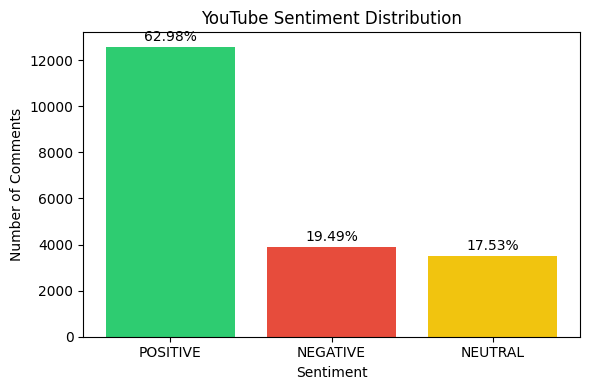

Sentiment distribution (% of total):

POSITIVE: 62.98%
NEGATIVE: 19.49%
NEUTRAL: 17.53%


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(YOUTUBE_SENTIMENT)

counts = df["sentiment_label"].value_counts()
percentages = (counts / counts.sum() * 100).round(2)

color_map = {
    "POSITIVE": "#2ECC71",
    "NEGATIVE": "#E74C3C",
    "NEUTRAL": "#F1C40F"
}

bar_colors = [color_map.get(label.upper(), "gray") for label in counts.index]


plt.figure(figsize=(6,4))
bars = plt.bar(counts.index, counts.values, color=bar_colors)
plt.title("YouTube Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)

for bar, pct in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + counts.max()*0.01,
        f"{pct}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


print("Sentiment distribution (% of total):\n")
for label, pct in percentages.items():
    print(f"{label}: {pct:.2f}%")


In [14]:
import pandas as pd

df = pd.read_csv(YOUTUBE_SENTIMENT)
df.columns = df.columns.str.lower()
print(f"Comments loaded: {len(df):,}")

text_col = next((c for c in ["text", "content", "body", "comment"] if c in df.columns), None)
like_col = next((c for c in ["likecount", "score", "likes"] if c in df.columns), None)

if text_col is None:
    raise ValueError("❌ No text column found (expected 'text', 'content', 'body', or 'comment').")
if like_col is None:
    print("⚠️ No likeCount/score column found — defaulting likes to 0.")
    df["likecount"] = 0
    like_col = "likecount"

# --- Top 15 NEGATIVE by likes ---
most_negative_upvoted = (
    df[df["sentiment_label"].str.lower().str.contains("neg")]
    .sort_values(like_col, ascending=False)
    .head(15)
)

print("\n🔴 Top 15 Most-Liked Negative Comments:\n")
for _, row in most_negative_upvoted.iterrows():
    print(f"💬 {str(row[text_col])[:500]}")
    print(f"   🔹 Sentiment: {row['sentiment_label']} ({row['sentiment_score']:.3f}) | Likes: {row[like_col]}\n")

# --- Top 15 POSITIVE by likes ---
most_positive_upvoted = (
    df[df["sentiment_label"].str.lower().str.contains("pos")]
    .sort_values(like_col, ascending=False)
    .head(15)
)

print("\n🟢 Top 15 Most-Liked Positive Comments:\n")
for _, row in most_positive_upvoted.iterrows():
    print(f"💬 {str(row[text_col])[:500]}")
    print(f"   🔹 Sentiment: {row['sentiment_label']} ({row['sentiment_score']:.3f}) | Likes: {row[like_col]}\n")

# --- Top 15 NEUTRAL by likes ---
most_neutral_upvoted = (
    df[df["sentiment_label"].str.lower().str.contains("neu")]
    .sort_values(like_col, ascending=False)
    .head(15)
)

print("\n🟡 Top 15 Most-Liked Neutral Comments:\n")
for _, row in most_neutral_upvoted.iterrows():
    print(f"💬 {str(row[text_col])[:500]}")
    print(f"   🔹 Sentiment: {row['sentiment_label']} ({row['sentiment_score']:.3f}) | Likes: {row[like_col]}\n")


Comments loaded: 19,968

🔴 Top 15 Most-Liked Negative Comments:

💬 Imagine Britney Spears came out and sang that song dam my hear was beating thinking she’s gonna walk out
   🔹 Sentiment: NEGATIVE (0.669) | Likes: 3392

💬 Cameraman being obsessed with Karol G is so real
   🔹 Sentiment: NEGATIVE (0.497) | Likes: 1290

💬 For those people saying tzuyu is off key, tzuyu is not feeling well.. These girls are exhausted! After their two-day concert in Singapore, they went back to Korea the next day, then flew to New York right after. After this show, they’ll fly back to Korea again, and once they arrive, they’ll fly to another country for another two-day concert.
   🔹 Sentiment: NEGATIVE (0.854) | Likes: 674

💬 WE NEEDED MORE!! THIS WAS TOO SHORT
   🔹 Sentiment: NEGATIVE (0.879) | Likes: 473

💬 Who don't get hyped enough
   🔹 Sentiment: NEGATIVE (0.551) | Likes: 398

💬 1:11:14 BARBIE FERREIRA AND TWICE IN THE SAME STAGE???? SLAYYYYYY
   🔹 Sentiment: NEGATIVE (0.629) | Likes: 344

💬 Not sure i

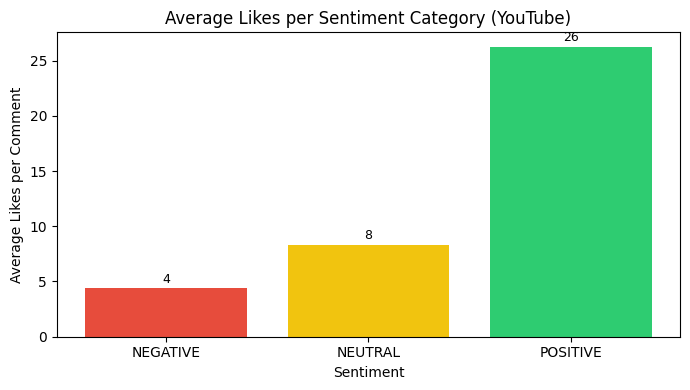

📊 Sentiment Popularity Summary:
NEGATIVE: 3892 comments | Avg Likes: 4.4 | Total Likes: 16996
NEUTRAL: 3500 comments | Avg Likes: 8.3 | Total Likes: 29166
POSITIVE: 12576 comments | Avg Likes: 26.2 | Total Likes: 330072


In [15]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv(YOUTUBE_SENTIMENT)
df.columns = df.columns.str.lower()


like_col = next((c for c in ["likecount", "score", "likes"] if c in df.columns), None)
if like_col is None:
    raise ValueError("❌ No like/score column found in dataset.")


sentiment_stats = df.groupby("sentiment_label")[like_col].agg(["mean", "sum", "count"]).reset_index()
sentiment_stats = sentiment_stats.sort_values("mean", ascending=False)


plt.figure(figsize=(7,4))


color_map = {
    "POSITIVE": "#2ECC71",
    "NEGATIVE": "#E74C3C",
    "NEUTRAL": "#F1C40F"
}


sentiment_stats['sentiment_label'] = pd.Categorical(sentiment_stats['sentiment_label'], ["NEGATIVE", "NEUTRAL", "POSITIVE"])
sentiment_stats = sentiment_stats.sort_values("sentiment_label")

bars = plt.bar(
    sentiment_stats["sentiment_label"],
    sentiment_stats["mean"],
    color=[color_map[label] for label in sentiment_stats["sentiment_label"]]
)
plt.title("Average Likes per Sentiment Category (YouTube)")
plt.ylabel("Average Likes per Comment")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)


for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + sentiment_stats["mean"].max()*0.01,
        f"{bar.get_height():.0f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


print("📊 Sentiment Popularity Summary:")
for _, row in sentiment_stats.iterrows():
    print(f"{row['sentiment_label']}: {row['count']} comments | Avg Likes: {row['mean']:.1f} | Total Likes: {row['sum']:.0f}")

**4.0 Text Frequency Analysis**

This part includes an analysis of the most frequent words in the dataset. From the most frequent or thematically relevant words, the top 10 most liked comments are reviewed, to gain deeper contextual awareness.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

df = pd.read_csv(CLEAN_YOUTUBE_DATA)

text_col = next((c for c in ["text","content","body","comment"] if c in df.columns), None)
if text_col is None:
    raise ValueError("No text column found.")

all_text = " ".join(df[text_col].dropna().astype(str).tolist())

vectorizer = CountVectorizer(stop_words="english", token_pattern=r"\b\w+\b")
X = vectorizer.fit_transform([all_text])

words = vectorizer.get_feature_names_out()
counts = X.sum(axis=0).tolist()[0]

word_counts = pd.DataFrame({"word": words, "count": counts})

custom_stopwords = {"s","t","g","1","m","la","000", 'y', 'don', 've', 'el', 'que', 'did'}
word_counts = word_counts[~word_counts["word"].isin(custom_stopwords)]

top_words = (
    word_counts
    .sort_values("count", ascending=False)
    .head(15)
    .reset_index(drop=True)
)

top_words.index = top_words.index + 1

print("Top 15 Words in the Dataset:")
display(
    top_words.style.set_properties(
        **{
            "border": "1px solid black",
            "text-align": "left",
        }
    )
)


Top 15 Words in the Dataset:


,word,count
1,twice,2158
2,love,1331
3,karol,1240
4,year,1221
5,like,874
6,vs,872
7,amazing,854
8,victoria,777
9,secret,742
10,best,705


In [5]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 100)

TOP_N_WORDS = 15
TOP_N_COMMENTS = 15
LIKES_COL = "likeCount"

for word in top_words["word"].head(TOP_N_WORDS):
    subset = df[
        df[text_col]
        .fillna("")
        .astype(str)
        .str.contains(rf"\b{word}\b", case=False, regex=True)
    ]

    if subset.empty:
        continue

    cols_to_show = [text_col, LIKES_COL] + (["orig_index"] if "orig_index" in df.columns else [])

    top_comments = (
        subset.sort_values(LIKES_COL, ascending=False)
              .head(TOP_N_COMMENTS)[cols_to_show]
              .reset_index(drop=True)
    )

    print(f"\n🔹 Top {TOP_N_COMMENTS} most-liked comments containing '{word}':\n")
    display(top_comments)



🔹 Top 15 most-liked comments containing 'twice':



,text,likeCount
0,Madison Beer ate. Twice ate. Carol G ate. Missy Elliot DEVOURED. omg I loved everyone who performed this year and the outfits were so beautiful.,6999
1,"58:48 Madison Beer 1:06:22 TWICE 1:12:30 Karol G 1:20:39 TOXIC by Britney Spears 1:22:25 1 Thing by Amerie 1:23:45 Never Leave You by Lumidee 1:27:29 Take Me Dancing by Doja Cat 1:29:04 NEW WOMAN by LISA ft. Rosalia 1:30:32 SPORT CARS by Tate Mcrae 1:32:51 Missy Elliot 1:39:45 FANTASY by Mariah Carey Angels 53:51 Jasmin Tookes 55:11 & 1:31:24 Adriana Lima 55:51 Doutzen Kroes 56:13 & 1:31:02 Alessandra Ambrosio 56:28 Lilly Aldridge 56:39 Joan Smalls 57:02 & 1:30:14 Barbara Palvin 57:11 Behati Prinslo 57:30 & 1:26:22 Candice Swanepoel 59:15 &1:29:28 Gigi Hadid 1:01:25 & 1:18:33 Irina Shayk 1:03:12 & 1:24:49 Angel Reese 1:03:58 & 1:21:41 Abby Champion 1:04:34 & 1:27:06 İmaan Hammam 1:04:44 &1:26:51 Anok Yai 1:07:50 Gabi Moura 1:08:26 Suni Lee 1:09:04 Quenlin Blackwell 1:09:38 Valantino Castro 1:09:55 Lila Moss 1:10:35 Iris Law 1:11:18 Barbie Ferreira 1:13:16 & 1:31:45 Bella Hadid 1:13:50 & 1:29:58 Alex Consanni 1:14:21 & 1:28:14 Amelia Gray 1:14:33 Stella Maxwell 1:16:55 & 1:28:44 Yasmin Wijnaldum 1:22:27 Xiao Wen Ju 1:23:55 Emily Ratajkowski 1:24:11 Mathilda Gvarliani 1:27:32 Ashley Graham İnterviews -8:41 Madison Beer -24:40 TWICE -27:36 Dylan Sprouse -30:18 Alex Consanni -34:51 Barbie Ferreira If you write down the angels I forgot to write about, I can add them.❤️ Like it so that it comes to the top and others can be arranged.",3128
2,"Thank you Victoria Secret for bringing Twice to the stage, thank you Tzuyu, you have worked hard, take care of your health, don't be sad and stay strong, Once will always be by your side to protect you",1746
3,So excited to see my girls TWICE here!!!!,1282
4,bringing out the pink collection with TWICE was such a smart move omg,1131
5,Whatever twice was wearing I need it they looked extra gorgeous 🥹🩷,1067
6,Thank you for inviting Twice for the fashion show. This is such a honor.,918
7,"LOVED how twice, Karol g, Maddison Beer, Missy Elliott ATE this vs show 🫰🏻💕",874
8,"I loved every minute of this year's Victoria's Secret, and the Twice girls were simply amazing. ❤",791
9,"TWICE QUEENS, THANK YOU VICTORIA'S SECRET💓",769



🔹 Top 15 most-liked comments containing 'love':



,text,likeCount
0,I love how all the singers brought a different vibe to the event,9862
1,I love how Jasmine is the first one to walk and she really shines with her pregnant runaway!,1258
2,I love how every race and size was incorporated in this production. This is such a breath of fresh air 🥰,1013
3,"TWICE being there made this live even more perfect , i love it",367
4,The opening segment is just the old times! This is exactly for what we love this show! So beautiful!,229
5,"What I love about Twice is that they sing and dance at the same time. It's incredible that with such a busy schedule, they've learned a show for just four members. ONCE, we're very lucky. This is the first time I've seen the entire show.",218
6,"I love when they bring different styles, different body shapes, diff cultures and awakes our Millennial blood right before the show ends.",209
7,"Watching the Victoria’s Secret Fashion Show for my K-pop queens, TWICE. As an ONCE, I feel extremely happy and emotional seeing them perform “This Is For” and “Strategy” for the models at this event. Seeing the global recognition they truly deserve, showcasing all their elegance, talent, and charisma on such an iconic stage, is simply unforgettable. They’ve once again proven why they are the pride of K-pop and ONCEs. TWICE, I love you forever! 💖✨👑",179
8,"KarolG representing Latinos, I love it 😭💜",116
9,"Oh my God, Karol G is incredibly amazing and iconic. I love her performance, her sensual and striking style, and she's also very beautiful. I didn't know she could model so well. 😮😮",107



🔹 Top 15 most-liked comments containing 'karol':



,text,likeCount
0,"You can see clearly why the OG’s are THE OG’s, they flirt with the camera and work so well with whatever outfit you put them on! Pls hire Karol G as a model, she has that it something with the camera, her segment was insane!",8412
1,"karol Gs presentation matched so well with the otfits I loved itt her outfit in the dark, the SPARKLE I NEED IT NOWWWW",4394
2,"58:48 Madison Beer 1:06:22 TWICE 1:12:30 Karol G 1:20:39 TOXIC by Britney Spears 1:22:25 1 Thing by Amerie 1:23:45 Never Leave You by Lumidee 1:27:29 Take Me Dancing by Doja Cat 1:29:04 NEW WOMAN by LISA ft. Rosalia 1:30:32 SPORT CARS by Tate Mcrae 1:32:51 Missy Elliot 1:39:45 FANTASY by Mariah Carey Angels 53:51 Jasmin Tookes 55:11 & 1:31:24 Adriana Lima 55:51 Doutzen Kroes 56:13 & 1:31:02 Alessandra Ambrosio 56:28 Lilly Aldridge 56:39 Joan Smalls 57:02 & 1:30:14 Barbara Palvin 57:11 Behati Prinslo 57:30 & 1:26:22 Candice Swanepoel 59:15 &1:29:28 Gigi Hadid 1:01:25 & 1:18:33 Irina Shayk 1:03:12 & 1:24:49 Angel Reese 1:03:58 & 1:21:41 Abby Champion 1:04:34 & 1:27:06 İmaan Hammam 1:04:44 &1:26:51 Anok Yai 1:07:50 Gabi Moura 1:08:26 Suni Lee 1:09:04 Quenlin Blackwell 1:09:38 Valantino Castro 1:09:55 Lila Moss 1:10:35 Iris Law 1:11:18 Barbie Ferreira 1:13:16 & 1:31:45 Bella Hadid 1:13:50 & 1:29:58 Alex Consanni 1:14:21 & 1:28:14 Amelia Gray 1:14:33 Stella Maxwell 1:16:55 & 1:28:44 Yasmin Wijnaldum 1:22:27 Xiao Wen Ju 1:23:55 Emily Ratajkowski 1:24:11 Mathilda Gvarliani 1:27:32 Ashley Graham İnterviews -8:41 Madison Beer -24:40 TWICE -27:36 Dylan Sprouse -30:18 Alex Consanni -34:51 Barbie Ferreira If you write down the angels I forgot to write about, I can add them.❤️ Like it so that it comes to the top and others can be arranged.",3128
3,"Last year I loved Tyla's performance, this year Karol G delivered everything",1735
4,Cameraman being obsessed with Karol G is so real,1290
5,"LOVED how twice, Karol g, Maddison Beer, Missy Elliott ATE this vs show 🫰🏻💕",874
6,I cant stop watching when Karol G preformed!!! LIKE WHAAAAT!! EVERYTHING was perfect and now she is an angel!!! What a comeback you made with this @victoriasecret!!! wowwwwwww,633
7,"I liked Karol G's presentation, her voice and outfits were incredible. She was the best .",625
8,"Karol G was MOST DEFINITELY the right choice. Everything was perfectly delivered, and she was fabulous!",608
9,Iconica Karol G ❤ LATINAS FOREVER ❤,523



🔹 Top 15 most-liked comments containing 'year':



,text,likeCount
0,100000 times better than last year. Thank you for listening to the people!! Stunning fabulous work from everyone,34945
1,"Whoever was in charge this year, knew the assignment. Great bend of what was and what’s new, glamour, drama, inclusivity, great looks, music. Loveeeeed",11099
2,They did NOT disappoint this year!!,8098
3,Madison Beer ate. Twice ate. Carol G ate. Missy Elliot DEVOURED. omg I loved everyone who performed this year and the outfits were so beautiful.,6999
4,I’m happy that it was better than last year. They brought back the volume in their hair and it just had the vibe again.,5991
5,"Last year I loved Tyla's performance, this year Karol G delivered everything",1735
6,NOT A SINGLE FLOP! They all ate down and it just keeps getting better year after year! 💜👏🏽,1131
7,Whoever’s was in charge of this year’s Victoria’s Secret show did an amazing job ! 👏,912
8,The girls totally slayed this. I’m so glad Victoria Secret listened to our feedback and gave the angels blowouts! I can’t wait until next year’s theme my gosh 🪽💖,881
9,"I loved every minute of this year's Victoria's Secret, and the Twice girls were simply amazing. ❤",791



🔹 Top 15 most-liked comments containing 'like':



,text,likeCount
0,"Bringing Madison was the best choice, she looks like a literal VS angel herself",8584
1,"58:48 Madison Beer 1:06:22 TWICE 1:12:30 Karol G 1:20:39 TOXIC by Britney Spears 1:22:25 1 Thing by Amerie 1:23:45 Never Leave You by Lumidee 1:27:29 Take Me Dancing by Doja Cat 1:29:04 NEW WOMAN by LISA ft. Rosalia 1:30:32 SPORT CARS by Tate Mcrae 1:32:51 Missy Elliot 1:39:45 FANTASY by Mariah Carey Angels 53:51 Jasmin Tookes 55:11 & 1:31:24 Adriana Lima 55:51 Doutzen Kroes 56:13 & 1:31:02 Alessandra Ambrosio 56:28 Lilly Aldridge 56:39 Joan Smalls 57:02 & 1:30:14 Barbara Palvin 57:11 Behati Prinslo 57:30 & 1:26:22 Candice Swanepoel 59:15 &1:29:28 Gigi Hadid 1:01:25 & 1:18:33 Irina Shayk 1:03:12 & 1:24:49 Angel Reese 1:03:58 & 1:21:41 Abby Champion 1:04:34 & 1:27:06 İmaan Hammam 1:04:44 &1:26:51 Anok Yai 1:07:50 Gabi Moura 1:08:26 Suni Lee 1:09:04 Quenlin Blackwell 1:09:38 Valantino Castro 1:09:55 Lila Moss 1:10:35 Iris Law 1:11:18 Barbie Ferreira 1:13:16 & 1:31:45 Bella Hadid 1:13:50 & 1:29:58 Alex Consanni 1:14:21 & 1:28:14 Amelia Gray 1:14:33 Stella Maxwell 1:16:55 & 1:28:44 Yasmin Wijnaldum 1:22:27 Xiao Wen Ju 1:23:55 Emily Ratajkowski 1:24:11 Mathilda Gvarliani 1:27:32 Ashley Graham İnterviews -8:41 Madison Beer -24:40 TWICE -27:36 Dylan Sprouse -30:18 Alex Consanni -34:51 Barbie Ferreira If you write down the angels I forgot to write about, I can add them.❤️ Like it so that it comes to the top and others can be arranged.",3128
2,anok yai’s first look was literally everything … like her walk fit the hat so goodd and her hair was angelicc,2898
3,anok yai's first look was literally everything... like her walk fit the hat so goodd and her was angelicc,725
4,I cant stop watching when Karol G preformed!!! LIKE WHAAAAT!! EVERYTHING was perfect and now she is an angel!!! What a comeback you made with this @victoriasecret!!! wowwwwwww,633
5,yes and she loved like the birth of venus!,304
6,So so proud of my twice girls Nayeon Momo Jihyo Tzuyu they devoured the stage I was literally in tears there success feels like us onces success thank you Victoria Secret for inviting and taking good care of TWICE ❤,274
7,"Agreed! I don’t even like her music, but as a Latina she really made me proud, that walk was AMAZING!!! She ate!",267
8,TWICE literally did so amazing like I was so overwhelmed when I saw them performing,261
9,"Can't believe i over slept 😭😭😭 TWICE x Victoria's secret FS was like a dream come true, and i ended up missing that!! 😓",251



🔹 Top 15 most-liked comments containing 'vs':



,text,likeCount
0,This is the first VS Fashion Show I’ve fully watched in YEARS. This was SO GOOD and Quenlin ATE!!,13720
1,"Bringing Madison was the best choice, she looks like a literal VS angel herself",8584
2,The OG just hit different. You can tell that they set the standard for VS. They are the true angels for VS,3013
3,10/10! This was a real superbowl for the girlies! Thank you for bringing back the OG VS Fashion Show!!!💖💖💖💖💖💖,2948
4,"As an OLD millennial, you did your thing with this show! Models were diverse and gorgeous and the musical acts were multi-cultural and entertaining. 100/10 KUDOS to the VS team!",1849
5,"LOVED how twice, Karol g, Maddison Beer, Missy Elliott ATE this vs show 🫰🏻💕",874
6,"VS is really getting the energy back, we actually wanna see more diversity and the creativy in the segments. I miss the rose petals falling, the snow, the christmas, the santa girl, we miss it sooo much.",555
7,Lets talk about how ICONIC Madison Beer was for Vs her performance left me breathless,553
8,thanks for inviting TWICE!!! they literally looked SOOOO good!!! their pink vibe totally suit vs,363
9,"Finally the REAL Victoria Secret Show is back !!! I have been a big fans of VS show, the production team did a great job this year. Happy to see many iconic VS models and new faces. Keep up the good work.🥰",307



🔹 Top 15 most-liked comments containing 'amazing':



,text,likeCount
0,Whoever’s was in charge of this year’s Victoria’s Secret show did an amazing job ! 👏,912
1,That was amazing.,819
2,"I loved every minute of this year's Victoria's Secret, and the Twice girls were simply amazing. ❤",791
3,As a 90’s baby seeing missy elliot on stage is iconic! Under construction was an amazing album! Her dancers were incredible! 😭😭💖,468
4,"Twice really did a good jop, jihyo with her steady and amazing voice, momo impressed me with her confidence and stability , nayeon with her looks and voice , and tzuyu even though she was sick and nervous did her best",375
5,"Loved the PINK ft. TWICE collab! They looked sooo good — I just wish they’d had a bit more stage time and better set design, but it was still amazing. Overall, the show was a 100/10, I loved it! 💖",368
6,TWICE and Karol G were absolutely amazing!!,274
7,"Agreed! I don’t even like her music, but as a Latina she really made me proud, that walk was AMAZING!!! She ate!",267
8,TWICE literally did so amazing like I was so overwhelmed when I saw them performing,261
9,They all ATEEE. Bringing twice was an AMAZING choice literally all the girls looked absolutely beautiful,256



🔹 Top 15 most-liked comments containing 'victoria':



,text,likeCount
0,This was the first Victoria’s Secret show I’ve ever watched. And it was perfect ❤,14386
1,They brought back the thing that made Victoria Fashion Show fun to watch which is absolutely insane fits matched with the underwear/lingerie that no one would wear but are stunning on the runway and make the show A SHOW! They brought back the drama we all wanted!,5146
2,"Honestly, the 2025 Victoria’s Secret Fashion Show totally satisfied me. Those fabulous outfits, gorgeous idols, singers, and of course, the stunning models! And Madison Beer? She absolutely nailed it. She’s an icon, a legend , just awesome! 😊💖",1776
3,"Thank you Victoria Secret for bringing Twice to the stage, thank you Tzuyu, you have worked hard, take care of your health, don't be sad and stay strong, Once will always be by your side to protect you",1746
4,Now THIS IS VICTORIA'S SECRET!!!!,1339
5,Whoever’s was in charge of this year’s Victoria’s Secret show did an amazing job ! 👏,912
6,The girls totally slayed this. I’m so glad Victoria Secret listened to our feedback and gave the angels blowouts! I can’t wait until next year’s theme my gosh 🪽💖,881
7,I finally think that Victoria Secret is BACKKK,796
8,"I loved every minute of this year's Victoria's Secret, and the Twice girls were simply amazing. ❤",791
9,"TWICE QUEENS, THANK YOU VICTORIA'S SECRET💓",769



🔹 Top 15 most-liked comments containing 'secret':



,text,likeCount
0,This was the first Victoria’s Secret show I’ve ever watched. And it was perfect ❤,14386
1,"Honestly, the 2025 Victoria’s Secret Fashion Show totally satisfied me. Those fabulous outfits, gorgeous idols, singers, and of course, the stunning models! And Madison Beer? She absolutely nailed it. She’s an icon, a legend , just awesome! 😊💖",1776
2,"Thank you Victoria Secret for bringing Twice to the stage, thank you Tzuyu, you have worked hard, take care of your health, don't be sad and stay strong, Once will always be by your side to protect you",1746
3,Now THIS IS VICTORIA'S SECRET!!!!,1339
4,Whoever’s was in charge of this year’s Victoria’s Secret show did an amazing job ! 👏,912
5,The girls totally slayed this. I’m so glad Victoria Secret listened to our feedback and gave the angels blowouts! I can’t wait until next year’s theme my gosh 🪽💖,881
6,I finally think that Victoria Secret is BACKKK,796
7,"I loved every minute of this year's Victoria's Secret, and the Twice girls were simply amazing. ❤",791
8,"TWICE QUEENS, THANK YOU VICTORIA'S SECRET💓",769
9,"Twice. The first Kpop girl group to perform at the Victoria secret fashion show. My girls grew to be so big , 10 years and a huge milestone, congratulations girls!",586



🔹 Top 15 most-liked comments containing 'best':



,text,likeCount
0,Bringing the OGs back was the best choice,23862
1,"Bringing Madison was the best choice, she looks like a literal VS angel herself",8584
2,"I liked Karol G's presentation, her voice and outfits were incredible. She was the best .",625
3,Karol G was the best section. The girls with their walk was POWERFUL,439
4,"Twice really did a good jop, jihyo with her steady and amazing voice, momo impressed me with her confidence and stability , nayeon with her looks and voice , and tzuyu even though she was sick and nervous did her best",375
5,"Twice was incredible, it was one of the best performances even though they weren't complete, that showed how professional they are despite not all the members being there. 🔥",343
6,OMG THAT WAS THE BEST THING IVE WATCHED ALL YEAR!,230
7,Best show ever!,222
8,"Great show but the gurl that walked while Karol G @1:16:57 had the best walk of the entire show, I literally got chills 🤌🏼🔥, and that turn at the end OMFG, she ate it!",196
9,"KAROL G ATEEE AND YOU CAN'T SAY ANY DIFFERENT!!!!! Her calm confidence, her stage presence, the stage visuals, the hand movements, the little interactions with the other models. Everything felt so well-thought-through and so fitting. Also her song choices LOOOVEEE. Honestly best performance in my opinion. PROUD LATINAAAAA🇨🇴🇨🇴🇨🇴",176



🔹 Top 15 most-liked comments containing 'omg':



,text,likeCount
0,Madison Beer ate. Twice ate. Carol G ate. Missy Elliot DEVOURED. omg I loved everyone who performed this year and the outfits were so beautiful.,6999
1,"OMG THEY'RE ALL BACK!!, The angels, the wings, the makeup, AND THE HAIRRRR!! Sooo happy wanna cryy :(",2064
2,bringing out the pink collection with TWICE was such a smart move omg,1131
3,this was SO much better than last years omg 😭😭,1056
4,Omg Karol’s performance ❤,262
5,OMG THAT WAS THE BEST THING IVE WATCHED ALL YEAR!,230
6,"1:06:26 OMG TWICEEEEE, TO BE HONEST, I ONLY SAW THIS BECAUSE OF KAROL G AND TWICE. JUST LIKE ALL THE MODELS DID GREAT, AND I DIDN'T TALK ABOUT THE ARTISTS 😭😭😭",202
7,"The opening for TWICE was so good, it made me scream while watching it in my room. When Nayeon, Momo, Jihyo, and Tzuyu came out and walked like runway models and decided to k!ll everyone with their looks, omg! 😩",142
8,THAT WAS SUCH A GOOD SHOW OMG,99
9,"TWICE ATE OMG, THEIR OUTFITS WERE ON POINT!!! THANK YOU VS???? 😍",88



🔹 Top 15 most-liked comments containing 'better':



,text,likeCount
0,100000 times better than last year. Thank you for listening to the people!! Stunning fabulous work from everyone,34945
1,I’m happy that it was better than last year. They brought back the volume in their hair and it just had the vibe again.,5991
2,NOT A SINGLE FLOP! They all ate down and it just keeps getting better year after year! 💜👏🏽,1131
3,this was SO much better than last years omg 😭😭,1056
4,"Loved the PINK ft. TWICE collab! They looked sooo good — I just wish they’d had a bit more stage time and better set design, but it was still amazing. Overall, the show was a 100/10, I loved it! 💖",368
5,Last year was better and full of energy,253
6,"My dear Tzuyu, I hope you get better. Despite being sick, you gave your best. I'm very proud of you. 🫶🏻",118
7,"it was the performances by tyla and lisa that made last year's fashion show so much better though the production was bad. and this year, production was good, but performances are so-so.",80
8,@luciaportillo1072ofc not? Honestly it’s a lot better than last year and things are always adapting and changing,64
9,Does everyone agree that this year was better than last year?,62



🔹 Top 15 most-liked comments containing 'good':



,text,likeCount
0,This is the first VS Fashion Show I’ve fully watched in YEARS. This was SO GOOD and Quenlin ATE!!,13720
1,the 2000s gossip girl vibes were such a good call,531
2,"Twice really did a good jop, jihyo with her steady and amazing voice, momo impressed me with her confidence and stability , nayeon with her looks and voice , and tzuyu even though she was sick and nervous did her best",375
3,"Loved the PINK ft. TWICE collab! They looked sooo good — I just wish they’d had a bit more stage time and better set design, but it was still amazing. Overall, the show was a 100/10, I loved it! 💖",368
4,thanks for inviting TWICE!!! they literally looked SOOOO good!!! their pink vibe totally suit vs,363
5,"Finally the REAL Victoria Secret Show is back !!! I have been a big fans of VS show, the production team did a great job this year. Happy to see many iconic VS models and new faces. Keep up the good work.🥰",307
6,So so proud of my twice girls Nayeon Momo Jihyo Tzuyu they devoured the stage I was literally in tears there success feels like us onces success thank you Victoria Secret for inviting and taking good care of TWICE ❤,274
7,"Adriana, Joan, Alessandra, Doutzen, Candace, Lily, AND Behati!!! Seeing them together makes me so emotional😭 Did I miss anyone?! We’re definitely missing Erin, Chanel and Rosie but this is as good as it’s gonna get it and I’m soaking it all UP!!",237
8,"​@joanamendiabuena6629 The vocals were really good and Momo improved so much, the only one that was a bit off to be fair was Tzuyu, and it was because she was sick, she alrededor confirmed on bubble and apologized, Nayeon and Jihyo's stability are out of this world, they sound like the record, and Momo was very present, it was really Tzuyu who had top problems mantaining her breath and is understandable if she is sick.",148
9,"The opening for TWICE was so good, it made me scream while watching it in my room. When Nayeon, Momo, Jihyo, and Tzuyu came out and walked like runway models and decided to k!ll everyone with their looks, omg! 😩",142



🔹 Top 15 most-liked comments containing 'just':



,text,likeCount
0,I’m happy that it was better than last year. They brought back the volume in their hair and it just had the vibe again.,5991
1,The OG just hit different. You can tell that they set the standard for VS. They are the true angels for VS,3013
2,"Honestly, the 2025 Victoria’s Secret Fashion Show totally satisfied me. Those fabulous outfits, gorgeous idols, singers, and of course, the stunning models! And Madison Beer? She absolutely nailed it. She’s an icon, a legend , just awesome! 😊💖",1776
3,"It was PERFECTTT, everything was so feminine and pink 😭😭💖 I just miss the huge gorgeous wings, but everything else was just 👌🏼👌🏼✨",1216
4,NOT A SINGLE FLOP! They all ate down and it just keeps getting better year after year! 💜👏🏽,1131
5,Just imagine kali uchis performing,959
6,SEE HOW BEAUTIFUL EVERYTHING WOULD BE IF THE WORLD COULD JUST BE RULED BY WOMEN?! PREACH!,545
7,"it was similar they just didn't do slick back hair and added led runway but the rest is similar, the same minimalist runway set",376
8,"Loved the PINK ft. TWICE collab! They looked sooo good — I just wish they’d had a bit more stage time and better set design, but it was still amazing. Overall, the show was a 100/10, I loved it! 💖",368
9,The opening segment is just the old times! This is exactly for what we love this show! So beautiful!,229



🔹 Top 15 most-liked comments containing 'models':



,text,likeCount
0,"As an OLD millennial, you did your thing with this show! Models were diverse and gorgeous and the musical acts were multi-cultural and entertaining. 100/10 KUDOS to the VS team!",1849
1,"Honestly, the 2025 Victoria’s Secret Fashion Show totally satisfied me. Those fabulous outfits, gorgeous idols, singers, and of course, the stunning models! And Madison Beer? She absolutely nailed it. She’s an icon, a legend , just awesome! 😊💖",1776
2,"The appearance of the models from the 2000s and those of today returning to their essence was perfect, in addition to the performances were incredible.",1408
3,"The themes, the songs, the wings, the models, everything was perfect this year i loved it",772
4,"Omggg Bella hadid, Irina, Adriana lima ,Gigi hadid Alex consani, Yasmin wijnaldum all queen models in one show!? I'm excitedddddd",467
5,"Finally the REAL Victoria Secret Show is back !!! I have been a big fans of VS show, the production team did a great job this year. Happy to see many iconic VS models and new faces. Keep up the good work.🥰",307
6,"1:06:26 OMG TWICEEEEE, TO BE HONEST, I ONLY SAW THIS BECAUSE OF KAROL G AND TWICE. JUST LIKE ALL THE MODELS DID GREAT, AND I DIDN'T TALK ABOUT THE ARTISTS 😭😭😭",202
7,"This is the Victoria Secret show we needed , we deserved. Thank you!!! Quality models , diversity , body positivity, and production value. Just the artists alone. The models truly stole the show and I need that denim and sparkly hoodie",192
8,"Watching the Victoria’s Secret Fashion Show for my K-pop queens, TWICE. As an ONCE, I feel extremely happy and emotional seeing them perform “This Is For” and “Strategy” for the models at this event. Seeing the global recognition they truly deserve, showcasing all their elegance, talent, and charisma on such an iconic stage, is simply unforgettable. They’ve once again proven why they are the pride of K-pop and ONCEs. TWICE, I love you forever! 💖✨👑",179
9,"KAROL G ATEEE AND YOU CAN'T SAY ANY DIFFERENT!!!!! Her calm confidence, her stage presence, the stage visuals, the hand movements, the little interactions with the other models. Everything felt so well-thought-through and so fitting. Also her song choices LOOOVEEE. Honestly best performance in my opinion. PROUD LATINAAAAA🇨🇴🇨🇴🇨🇴",176


 **5.0 Topic Modelling**

This part conducts topic modelling on the entire dataset using semantic embeddings, which capture the meaning of the word and don’t rely exclusively on frequency patterns.

In [18]:
!pip install -q bertopic sentence-transformers umap-learn hdbscan nltk

import pandas as pd
import nltk
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

df_yt = pd.read_csv(CLEAN_YOUTUBE_DATA)
print(f"✅ Loaded cleaned YouTube dataset with {len(df_yt):,} rows")

text_col = next((c for c in ["comment", "text", "content", "body"] if c in df_yt.columns), None)
if text_col is None:
    raise ValueError("❌ No text column found (expected one of: comment, text, content, body).")

df_yt[text_col] = df_yt[text_col].fillna("").astype(str)

df_yt = df_yt[df_yt[text_col].str.strip().ne("")].copy()
print(f"🧹 Kept all {len(df_yt):,} comments")

df_yt["char_len"] = df_yt[text_col].str.len()
df_yt["is_short"] = df_yt["char_len"] < 5

nltk.download("stopwords")

stopwords_multi = (
    set(stopwords.words("english"))
    | set(stopwords.words("spanish"))
    | set(stopwords.words("portuguese"))
    | {
        "https", "http", "www", "com", "jpg", "removed", "deleted", "amp",
        "vs", "victoria", "secret", "victorias", "show",
        "like", "really", "girl", "girls", "omg", "lol",
        "video", "watching", "watched", "youtube"
    }
)
stopwords_multi = list(stopwords_multi)

vectorizer_model = CountVectorizer(
    stop_words=stopwords_multi,
    token_pattern=r"[A-Za-z\u00C0-\u00FF']{3,}",
    min_df=2,
    max_df=0.9,
    ngram_range=(1, 2)
)

embedding_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    language="multilingual",
    min_topic_size=50,
    calculate_probabilities=True,
    verbose=True
)

texts = df_yt[text_col].tolist()
topics, probs = topic_model.fit_transform(texts)
df_yt["bertopic_topic"] = topics


pd.set_option("display.max_colwidth", None)
topic_info = topic_model.get_topic_info()

real_topics = topic_info[topic_info["Topic"] != -1].copy()
real_topics = real_topics.sort_values(["Count", "Topic"], ascending=[False, True])

old_to_new = {
    old_topic: new_rank
    for new_rank, old_topic in enumerate(real_topics["Topic"].tolist(), start=1)
}

df_yt["bertopic_topic_ranked"] = (
    df_yt["bertopic_topic"]
      .map(old_to_new)
      .fillna(-1)
      .astype(int)
)


new_to_old = {v: k for k, v in old_to_new.items()}


print(f"\n📊 Topic overview: total {len(topic_info)} topics (including -1 outliers)")
print("\n✅ Sanity check (all rows assigned a topic):")
print("Rows in df_yt:", len(df_yt))
print("Topic assignments:", df_yt["bertopic_topic"].notna().sum())

print("\nTopic distribution (original topic IDs):")
print(df_yt["bertopic_topic"].value_counts().sort_index())

print("\nTopic distribution (ranked by size, starting at 1):")
print(df_yt["bertopic_topic_ranked"].value_counts().sort_index())

# Top 15 topics by size
top_ranks = sorted(new_to_old.keys())[:15]

print("\n📊 Top 15 non-outlier topics (ranked by size):")
for r in top_ranks:
    old_topic = new_to_old[r]
    count = int(topic_info.loc[topic_info["Topic"] == old_topic, "Count"].iloc[0])
    name = topic_info.loc[topic_info["Topic"] == old_topic, "Name"].iloc[0]
    print(f"Ranked Topic {r:2d} (orig {old_topic:3d}) | Count={count:6d} | {name}")

print("\n🔍 Inspecting TOP 15 topics (ranked) with 15 example comments each:")
for r in top_ranks:
    old_topic = new_to_old[r]

    print("\n" + "=" * 60)
    print(f"🧩 Ranked Topic {r} (original topic {old_topic})")
    print("Top words:", topic_model.get_topic(old_topic))
    print("\n💬 Sample comments:")

    sample_comments = df_yt.loc[df_yt["bertopic_topic_ranked"] == r, text_col].head(15)
    for i, c in enumerate(sample_comments, start=1):
        print(f"{i:2d}. {c}")

outlier_mask = df_yt["bertopic_topic"] == -1
outlier_count = int(outlier_mask.sum())
print("\n📌 Outlier diagnostics:")
print(f"Outlier (-1) comments: {outlier_count:,} / {len(df_yt):,} ({outlier_count/len(df_yt)*100:.1f}%)")

if outlier_count > 0:
    short_outliers = int(df_yt.loc[outlier_mask, "is_short"].sum())
    print(
        f"Short (<5 chars) within outliers: {short_outliers:,} / {outlier_count:,} "
        f"({short_outliers/outlier_count*100:.1f}%)"
    )


✅ Loaded cleaned YouTube dataset with 19,968 rows
🧹 Kept all 19,968 comments


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2026-01-03 19:41:27,644 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/624 [00:00<?, ?it/s]

2026-01-03 19:42:02,287 - BERTopic - Embedding - Completed ✓
2026-01-03 19:42:02,290 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-03 19:42:27,808 - BERTopic - Dimensionality - Completed ✓
2026-01-03 19:42:27,810 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-03 19:42:42,561 - BERTopic - Cluster - Completed ✓
2026-01-03 19:42:42,571 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-03 19:42:42,969 - BERTopic - Representation - Completed ✓



📊 Topic overview: total 75 topics (including -1 outliers)

✅ Sanity check (all rows assigned a topic):
Rows in df_yt: 19968
Topic assignments: 19968

Topic distribution (original topic IDs):
bertopic_topic
-1     5276
 0      907
 1      849
 2      735
 3      672
       ... 
 69      58
 70      55
 71      53
 72      51
 73      50
Name: count, Length: 75, dtype: int64

Topic distribution (ranked by size, starting at 1):
bertopic_topic_ranked
-1     5276
 1      907
 2      849
 3      735
 4      672
       ... 
 70      58
 71      55
 72      53
 73      51
 74      50
Name: count, Length: 75, dtype: int64

📊 Top 15 non-outlier topics (ranked by size):
Ranked Topic  1 (orig   0) | Count=   907 | 0_quen_doutzen_quenlin_quennnn
Ranked Topic  2 (orig   1) | Count=   849 | 1_starts_baby_twice_timestamp
Ranked Topic  3 (orig   2) | Count=   735 | 2_dimension_ateee_created_creator
Ranked Topic  4 (orig   3) | Count=   672 | 3_karol_karol karol_karol best_karolg
Ranked Topic  5 (orig 